In [1]:
# Cell 1
#
# Start with importing the necessary packages
import os
import sys
import argparse
import numpy as np
import scipy.optimize
#import astropy.io.fits as pyfits
import matplotlib 
import matplotlib.pyplot as plt

# To ensure interactive plots
from matplotlib import interactive
interactive(True)

# 
# Useful parameters
c = 299798        # speed of light (km/s)
pi = np.pi


# For interactive plots
%matplotlib notebook

In [3]:
# Cell 2
# Open file, read in data, close file

# Main data directory with your ascii file (don't use \ in the name, always use /)
directory = "/Users/nikitasfilosofof/Documents/astronomy-nighttime-run/20220117"


# Name of the file with your spectrum in ascii formate (xaxis = wavelength; yaxis = intensity)
sourcefile = "sourcespectrum.txt"


# Open file
spectralfile = open(directory + "/" + sourcefile)

# Read in data
data = np.genfromtxt(spectralfile)
lambda_spec = data[:,0]
fnspec = data[:,1]

# Close file
spectralfile.close()


Investigate the lines in your spectrum using the zoom button and the home button (to restore).

Choose a line to investigate further.



<IPython.core.display.Javascript object>


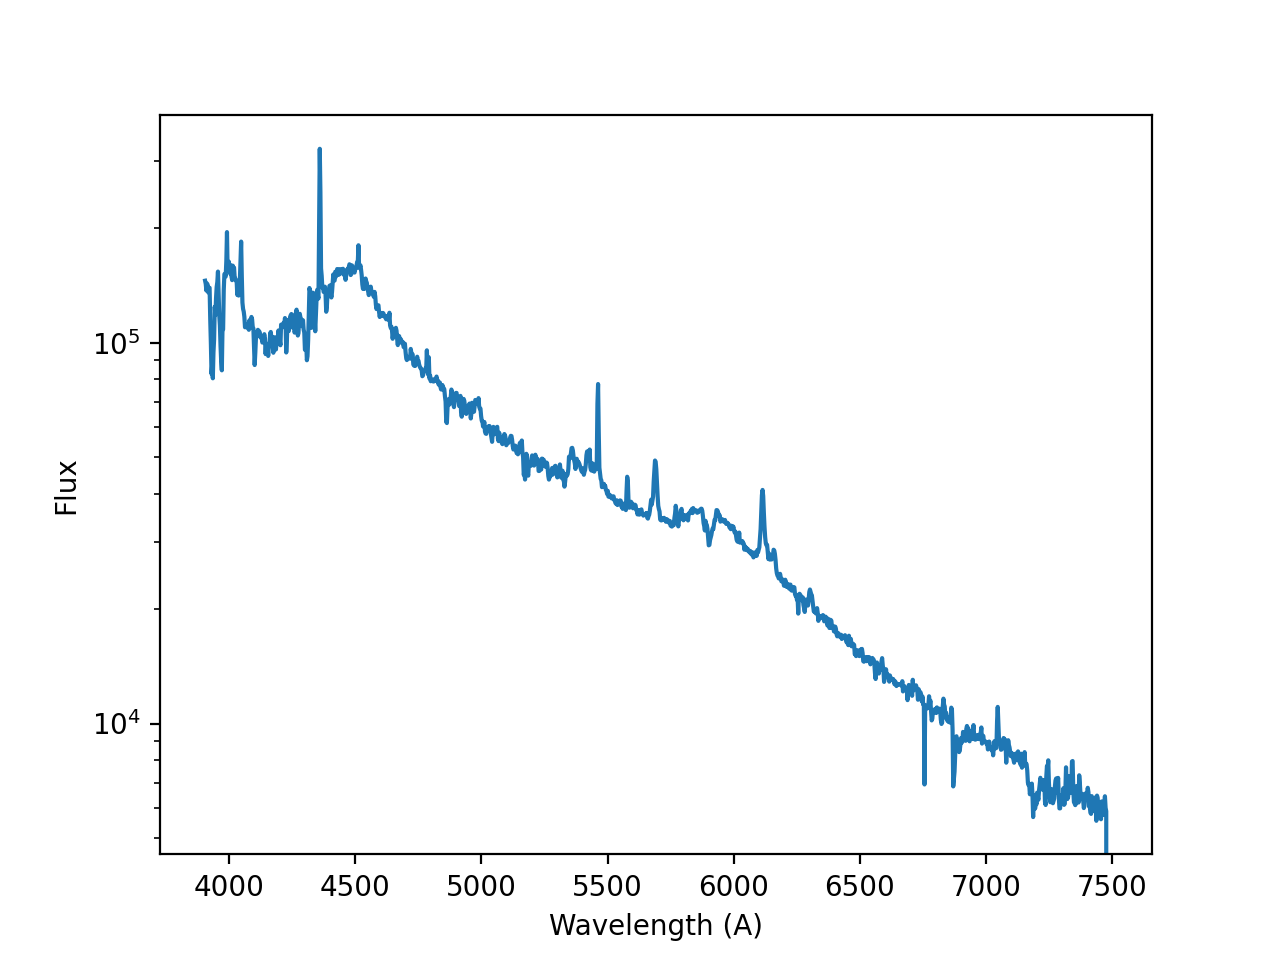

In [4]:
# Cell 3
# Interactively investigate your spectrum
print ("")
print ("Investigate the lines in your spectrum using the zoom button and the home button (to restore).")
print ("")
print ("Choose a line to investigate further.")
print ("")

# Plot spectrum
plt.figure()
plt.plot(lambda_spec, fnspec)
plt.xlabel('Wavelength (A)')
plt.ylabel('Flux')
plt.yscale('log')
#plt.xlim(6550,6570)             # Use this if you want to change the x-axis range manual
#plt.ylim(5.5e-1,1.1)            # Use this if you want to change the y-axis range manual
plt.show()

<IPython.core.display.Javascript object>


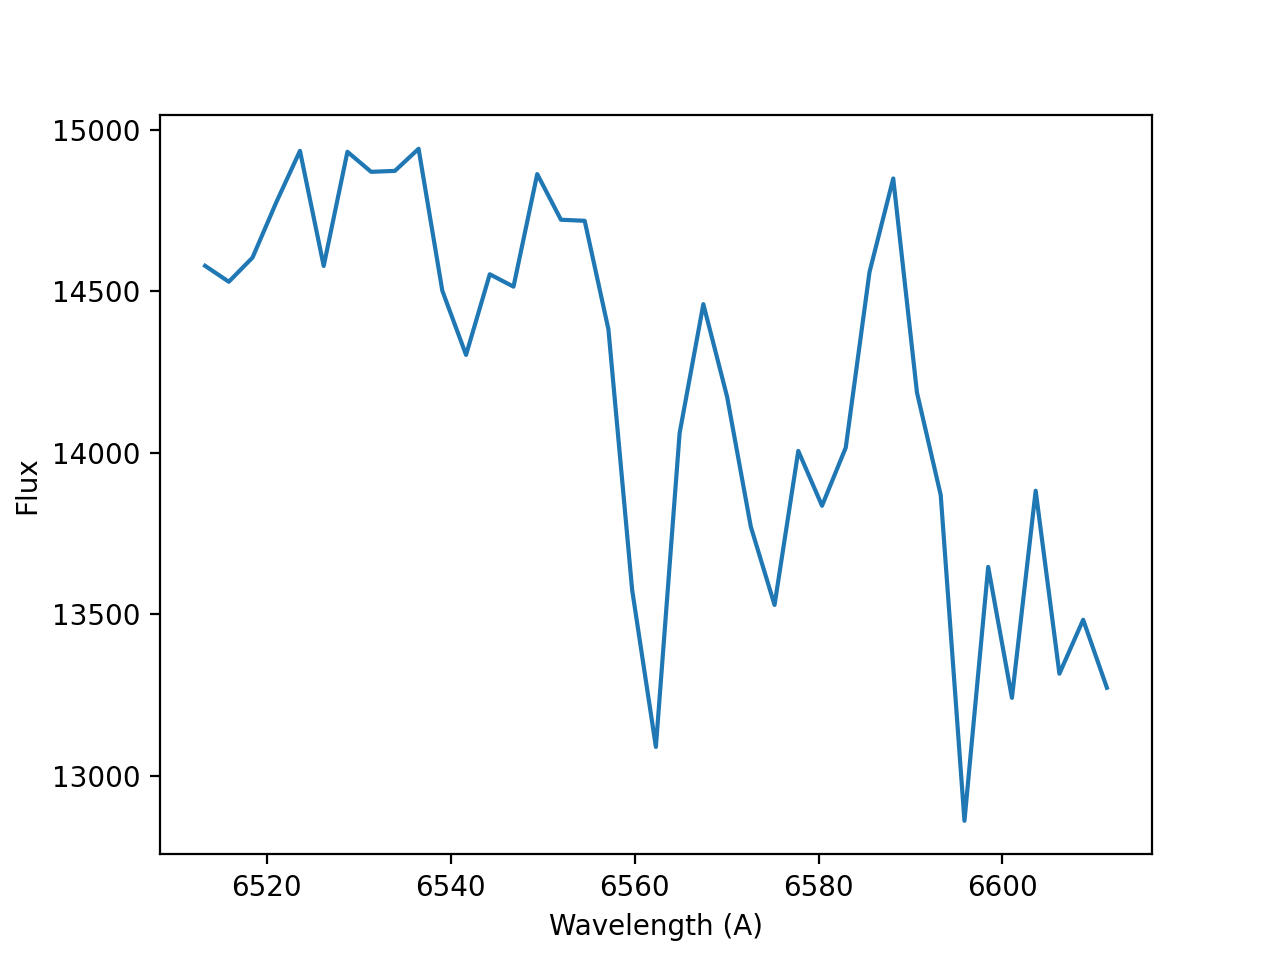

In [5]:
# Cell 4
#
# Select the wavelength region of the line
# "targetline" is the center of your plot and fit (in cell 5) region
# "wavrange" is the wavelength range that is used  in the plot and in the fit (in cell 5)
#
targetline = 6563
wavrange = 50

lim_fit_left = targetline - wavrange
lim_fit_right = targetline + wavrange

i_line = np.where((lambda_spec > lim_fit_left) & (lambda_spec < lim_fit_right))
wav_line = lambda_spec[i_line]
flux_line = fnspec[i_line]


# Plot the selected region for inspection. Adjust line region above if necessary.
# Plot spectrum
plt.figure()
plt.plot(wav_line, flux_line)
plt.xlabel('Wavelength (A)')
plt.ylabel('Flux')
#plt.yscale('log')
plt.show()

<IPython.core.display.Javascript object>


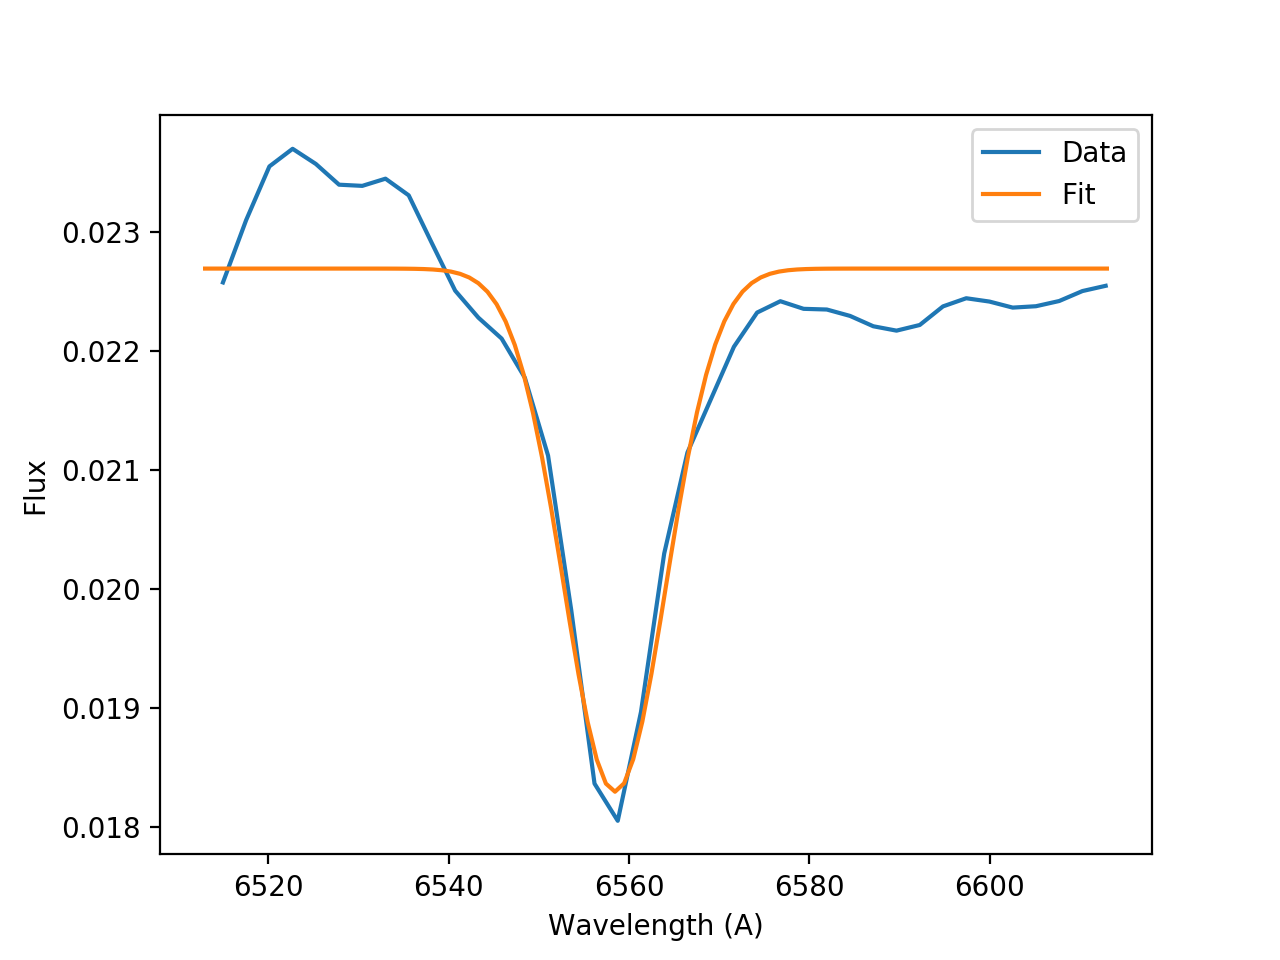

In [30]:
# Cell 5
#
# Determine the central wavelength and the width of the line
#
# Define several model functions (Gaussian) to be used to fit spectral lines later on:
#   gauss                    A simple Gaussian function
#   doublegauss              A function containing to Gaussians to fit complex line profiles
#   doublegaussonecneter     Similar to 'doublegauss' but now the central frequency of the line 
#                            is fixed between the two Gaussians
#   triplegauss              Use three Gaussians as fit function
#
def gauss(x, a, b, c, d):
    return d + a * np.exp(-1. * ((x - c)/b)**2)

def doublegauss(x, a, b, c, d, e, f, g):
    return d + a * np.exp(-1. * ((x - c)/b)**2) +  e * np.exp(-1. * ((x - g)/f)**2)

def doublegaussonecenter(x, a, b, c, d, e, f):
    return d + a * np.exp(-1. * ((x - c)/b)**2) +  e * np.exp(-1. * ((x - c)/f)**2)

def triplegauss(x, a, b, c, d, e, f, g, h, i, j):
    return d + a * np.exp(-1. * ((x - c)/b)**2) +  e * np.exp(-1. * ((x - g)/f)**2) + h * np.exp(-1. * ((x - j)/i)**2)


# Select how many Gaussians you want to fit to the data
# Note: three Gaussian might be hard to fit to the data
#
typegauss = "one"
#typegauss = "two"
#typegauss = "twosamecenter"
#typegauss = "three"

# Here you can give input values for the lines. 
# Changing these values could give you a good/reasonable, while the defaults might not
norm = 0.0
#flux1 = np.max(flux_line) - norm
flux1 = -0.5
lambda1 = targetline 

#flux2 = np.max(flux_line) - norm
flux2 = -0.1
lambda2 = targetline 

#flux3 = np.max(flux_line) - norm
flux3 = -0.0
lambda3 = targetline


# Algorithm to perform minimization (from Python manual).
#  ‘trf’    : Trust Region Reflective algorithm, particularly suitable for large sparse problems with bounds. Generally robust method.
#  ‘dogbox’ : dogleg algorithm with rectangular trust regions, typical use case is small problems with bounds. Not recommended for problems with rank-deficient Jacobian.
#      ‘lm’ : Levenberg-Marquardt algorithm as implemented in MINPACK. Doesn’t handle bounds and sparse Jacobians. Usually the most efficient method for small unconstrained problems.
#
# Rudy comment: 'lm' is relatively quick but does not always converge, 'trf' is more robust but make take some time so be patient



methodAOL = "trf"
methodAOL = "lm"
#methodAOL = "dogbox"


# Fit the data 
if typegauss == "one":
    popt,pcov=scipy.optimize.curve_fit(gauss,wav_line,flux_line,p0=[flux1,wavrange,lambda1,norm],method=methodAOL)
    
if typegauss == "two":
    popt,pcov=scipy.optimize.curve_fit(doublegauss,wav_line,flux_line,p0=[flux1,wavrange,lambda1,norm,flux2,wavrange,lambda2],method=methodAOL)

if typegauss == "twosamecenter":
    popt,pcov=scipy.optimize.curve_fit(doublegaussonecenter,wav_line,flux_line,p0=[flux1,wavrange,lambda1,norm,flux2,wavrange],method=methodAOL)
       
if typegauss =="three":
    popt,pcov=scipy.optimize.curve_fit(triplegauss,wav_line,flux_line,p0=[flux1,wavrange,lambda1,norm,flux2,wavrange,lambda2, flux3,wavrange,lambda3],method=methodAOL)

            
errs = np.sqrt(np.diag(pcov))
center_wav = np.linspace(lim_fit_left, lim_fit_right, 100)


# Set 'plotindiv' to True if you want to plot the individual Guassians
plotindiv = False
plotindiv = True

# Plot the line + fit for inspection
plt.figure()
plt.plot(wav_line, flux_line, label='Data')
if typegauss == "one":
    plt.plot(center_wav, gauss(center_wav, *popt), label='Fit')

if typegauss == "two":
    plt.plot(center_wav, doublegauss(center_wav, *popt), label='Fit')
    if plotindiv:
        plt.plot(center_wav, doublegauss(center_wav, popt[0],popt[1],popt[2],popt[3],0.,popt[5], popt[6]), label='Gaussian 1')
        plt.plot(center_wav, doublegauss(center_wav, popt[0],0.,popt[2],popt[3],popt[4],popt[5], popt[6]), label='Gaussian 2')
    
if typegauss == "twosamecenter":
    plt.plot(center_wav, doublegaussonecenter(center_wav, *popt), label='Fit')
    if plotindiv:
        plt.plot(center_wav, doublegaussonecenter(center_wav, popt[0],popt[1],popt[2],popt[3],0.,popt[5]), label='Gaussian 1')
        plt.plot(center_wav, doublegaussonecenter(center_wav, popt[0],0.,popt[2],popt[3],popt[4],popt[5]), label='Gaussian 2')
        
if typegauss == "three":
    plt.plot(center_wav, triplegauss(center_wav, *popt), label='Fit')
    if plotindiv:
        plt.plot(center_wav, triplegauss(center_wav, popt[0],popt[1],popt[2],popt[3],0.,popt[5], popt[6], 0., popt[8], popt[9]), label='Gaussian 1')
        plt.plot(center_wav, triplegauss(center_wav, popt[0],0.,popt[2],popt[3],popt[4],popt[5], popt[6], 0., popt[8], popt[9]), label='Gaussian 2')
        plt.plot(center_wav, triplegauss(center_wav, popt[0],0.,popt[2],popt[3],0.,popt[5], popt[6], popt[7], popt[8], popt[9]), label='Gaussian 3')

                
plt.xlabel('Wavelength (A)')
plt.ylabel('Flux')
plt.legend()
#plt.yscale('log')          # Use if you want to plot the intensity as log scale
plt.show()

In [31]:
# Cell 6
# Print some line information
#
# Calculate equivalent width:
# Integrate the Gaussian. Using the 'Intergral of an arbitrary Guassian function at:
# https://en.wikipedia.org/wiki/Gaussian_function
# (Note in our definiation b = c and c = sqrt(2)b)
# The resulting EW = -1 * (a|b|sqrt(pi)/d)
# (note: absorption lines have postive EW and emission lines negative EW)
# (note: EW have to be normalized to a continuum level of unit)

# FWHM = 2.355 * sigma in a Gaussion function. From our Gaussians it is true that b = sqrt(2)*sigma so
# FWMH = 2.355 * sigma/sqrt(2)


if typegauss == "one":
    EW1 = -1*popt[0] * np.absolute(popt[1]) * np.sqrt(pi)/popt[3]
    print('Line properties:')
    print('  Wavelength center: \t {0} +- {1} Angstrom'.format(popt[2], errs[2]))
    print('  FWHM: \t \t  {0} +- {1} Angstrom' .format(2.355*popt[1]/np.sqrt(2), 2.355*errs[1]/np.sqrt(2)))
    print('  Equivalent width: \t {0} Angstrom' .format(EW1))
    print('  Line intensity: \t {0} +- {1} Relative units' .format(popt[0], errs[0]))

if typegauss == "two":
    EW1 = -1*popt[0] * np.absolute(popt[1]) * np.sqrt(pi)/popt[3]
    EW2 = -1*popt[4] * np.absolute(popt[5]) * np.sqrt(pi)/popt[3]
    print('Line 1 properties:')
    print('  Wavelength center: \t {0} +- {1} Angstrom'.format(popt[2], errs[2]))
    print('  FWHM: \t \t {0} +- {1} Angstrom' .format(2.355*popt[1]/np.sqrt(2), 2.355*errs[1]/np.sqrt(2)))
    print('  Equivalent width: \t {0} Angstrom' .format(EW1))
    print('  Line intensity: \t {0} +- {1} Relative units' .format(popt[0], errs[0]))
    print ('') 
    print('Line 2 properties:')
    print('  Wavelength center: \t {0} +- {1} Angstrom'.format(popt[6], errs[6]))
    print('  FWHM: \t \t {0} +- {1} Angstrom' .format(2.355*popt[5]/np.sqrt(2), 2.355*errs[5]/np.sqrt(2)))
    print('  Equivalent width: \t {0} Angstrom' .format(EW2))
    print('  Line intensity: \t {0} +- {1} Relative units' .format(popt[4], errs[4]))
    
if typegauss == "twosamecenter":
    EW1 = -1*popt[0] * np.absolute(popt[1]) * np.sqrt(pi)/popt[3]
    EW2 = -1*popt[4] * np.absolute(popt[5]) * np.sqrt(pi)/popt[3]
    print('Line 1 properties:')
    print('  Wavelength center: \t {0} +- {1} Angstrom'.format(popt[2], errs[2]))
    print('  FWHM: \t \t {0} +- {1} Angstrom' .format(2.355*popt[1]/np.sqrt(2), 2.355*errs[1]/np.sqrt(2)))
    print('  Equivalent width:\t {0} Angstrom' .format(EW1))
    print('  Line intensity: \t {0} +- {1} Relative units' .format(popt[0], errs[0]))
    print ('') 
    print('Line 2 properties:')
    print('  Wavelength is the same as for line 1')
    print('  FWHM: \t \t  {0} +- {1} Angstrom' .format(2.355*popt[5]/np.sqrt(2), 2.355*errs[5]/np.sqrt(2)))
    print('  Equivalent width: \t {0} Angstrom' .format(EW2))
    print('  Line intensity: \t {0} +- {1}Relative units' .format(popt[4], errs[4]))
        
if typegauss == "three":
    EW1 = -1*popt[0] * np.absolute(popt[1]) * np.sqrt(pi)/popt[3]
    EW2 = -1*popt[4] * np.absolute(popt[5]) * np.sqrt(pi)/popt[3]
    EW3 = -1*popt[7] * np.absolute(popt[5]) * np.sqrt(pi)/popt[3]
    print('Line 1 properties:')
    print('  Wavelength center: \t {0} +- {1} Angstrom'.format(popt[2], errs[2]))
    print('  FWHM: \t \t  {0} +- {1} Angstrom' .format(2.355*popt[1]/np.sqrt(2), 2.355*errs[1]/np.sqrt(2)))
    print('  Equivalent width: \t {0} Angstrom' .format(EW1))
    print('  Line intensity: \t {0} +- {1} Relative units' .format(popt[0], errs[0]))
    print ('') 
    print('Line 2 properties:')
    print('  Wavelength center: \t {0} +- {1} Angstrom'.format(popt[6], errs[6]))
    print('  FWHM: \t \t {0} +- {1} Angstrom' .format(2.355*popt[5]/np.sqrt(2), 2.355*errs[5]/np.sqrt(2)))
    print('  Equivalent width: \t {0} Angstrom' .format(EW2))
    print('  Line intensity: \t {0} +- {1} Relative units' .format(popt[4], errs[4]))
    print ('') 
    print('Line 3 properties:')
    print('  Wavelength center: \t {0} +- {1} Angstrom'.format(popt[9], errs[9]))
    print('  FWHM: \t \t {0} +- {1} Angstrom' .format(2.355*popt[8]/np.sqrt(2), 2.355*errs[8]/np.sqrt(2)))
    print('  Equivalent width: \t {0} Angstrom' .format(EW2))
    print('  Line intensity: \t {0} +- {1} Relative units' .format(popt[7], errs[7]))

Line properties:
  Wavelength center: 	 6558.446954981197 +- 0.4223912643148695 Angstrom
  FWHM: 	 	  13.33210300616289 +- 1.0633149009072362 Angstrom
  Equivalent width: 	 2.74653143960863 Angstrom
  Line intensity: 	 -0.004391750186335383 +- 0.00029042558442729516 Relative units


In [32]:
# Cell 7
#
# Calculate redshift & velocity
#
#
# define the needed functions
def lambda_to_v(L0, L):
    '''
    Calculate redshift for selected spectral line.
    L0 and L are the rest wavelength and measured line center.
    Returns velocity in km/s.
    '''
    v = c * (L - L0)/L0
    return v


def redshift(L0, L):
    '''
    Calculate line redshift. L0 and L are the rest wavelength 
    and measured line center.
    '''
    z = L0/L - 1. 
    return z

# Rest wavelengths spectral lines (Angstrom)
L0_HAlpha = 6562.8;
L0_HBeta = 4861.332;
L0_HGamma= 4340.472;
L0_HDelta = 4101.734;
L0_LyAlpha = 1215;
L0_MgII = 2796.5;

lineID = L0_HAlpha
#lineID = L0_HBeta
#lineID = 5006.8


# Print results
offset = popt[2] - lineID
z = redshift(lineID, popt[2])
z_err = redshift(lineID, popt[2]+errs[2]) - z
v = z*c
v_err = z_err*c

print('Line properties:')
print('  Offset: \t \t {0} Angstrom'.format(offset))
print('  Redshift: \t \t {0} +- {1} '.format(z, z_err))
print('  Velocity: \t \t {0} +- {1} km/s'.format(v, v_err))


if typegauss == "two":
    offset = popt[6] - lineID
    z = redshift(lineID, popt[6])
    z_err = redshift(lineID, popt[6]+errs[6]) - z
    v = z*c
    v_err = z_err*c
    print('Line 2 properties:')
    print('  Offset: \t \t {0} Angstrom'.format(offset))
    print('  Redshift: \t \t {0} +- {1} '.format(z, z_err))
    print('  Velocity: \t \t {0} +- {1} km/s'.format(v, v_err))
    
    
if typegauss == "three":
    offset = popt[6] - lineID
    z = redshift(lineID, popt[6])
    z_err = redshift(lineID, popt[6]+errs[6]) - z
    v = z*c
    v_err = z_err*c
    print('Line 2 properties:')
    print('  Offset: \t \t {0} Angstrom'.format(offset))
    print('  Redshift: \t \t {0} +- {1} '.format(z, z_err))
    print('  Velocity: \t \t {0} +- {1} km/s'.format(v, v_err))
  
    offset = popt[9] - lineID
    z = redshift(lineID, popt[9])
    z_err = redshift(lineID, popt[9]+errs[9]) - z
    v = z*c
    v_err = z_err*c
    print('Line 3 properties:')
    print('  Offset: \t \t {0} Angstrom'.format(offset))
    print('  Redshift: \t \t {0} +- {1} '.format(z, z_err))
    print('  Velocity: \t \t {0} +- {1} km/s'.format(v, v_err))
    
    
    
starrot = False
#starrot = True

if starrot:
    print('')    
    FWHM1 = 2.355*popt[1]/np.sqrt(2)
    rotvel1 = FWHM1/2.355/lineID * c
    print('FWHM of line 1: \t {0} Angstrom'.format(FWHM1))
    print('Rotation velocity of star: {0} km/s'.format(rotvel1))   
    if typegauss == "two" or typegauss == "twosamecenter":
        FWHM2 = 2.355*popt[5]/np.sqrt(2)
        rotvel2 = FWHM2/2.355/lineID * c    
        print('')
        print('Alternatively, the rotation velocity might also be given by line 2 and not line 1')
        print('FWHM of line 2: \t {0} Angstrom'.format(FWHM2))
        print('Rotation velocity of star: {0} km/s'.format(rotvel2))
    if typegauss == "three":
        FWHM2 = 2.355*popt[5]/np.sqrt(2)
        rotvel2 = FWHM2/2.355/lineID * c  
        FWHM3 = 2.355*popt[8]/np.sqrt(2)
        rotvel3 = FWHM3/2.355/lineID * c  
       
        print('')
        print('Alternatively, the rotation velocity might also be given by line 2')
        print('FWHM of line 2: \t {0} Angstrom'.format(FWHM2))
        print('Rotation velocity of star: {0} km/s'.format(rotvel2))
        print('')
        print('Alternatively, the rotation velocity might also be given by line 3')
        print('FWHM of line 3: \t {0} Angstrom'.format(FWHM3))
        print('Rotation velocity of star: {0} km/s'.format(rotvel3))
        
    
 

Line properties:
  Offset: 	 	 -4.353045018802732 Angstrom
  Redshift: 	 	 0.0006637310705848165 +- -6.444275624484241e-05 
  Velocity: 	 	 198.9852474991868 +- -19.319809436691266 km/s
